In [1]:
#importing all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline  
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import random
from random import shuffle

from tqdm import tqdm
import cv2

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model,model_from_json
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop,Adadelta,Adam,Adamax,SGD
from keras import backend as K
from keras.layers import Dropout,Flatten,AveragePooling2D,MaxPooling2D,Conv2D,Activation,BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator



In [2]:
from IPython.display import Image

In [3]:
#setting path to dataset 
curr_path = 'C:/Users/Akhil Namboodiri/Downloads/recaptcha-dataset-main'
data_path = 'C:/Users/Akhil Namboodiri/Downloads/recaptcha-dataset-main/recaptcha-dataset-main/Large'

In [4]:
def sharpen(image):
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

In [5]:
def enhance_contrast(image_matrix, bins=256):
    image_flattened = image_matrix.flatten()
    image_hist = np.zeros(bins)

    # frequency count of each pixel
    for pix in image_matrix:
        image_hist[pix] += 1

    # cummulative sum
    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * 255
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

Bicycle


100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 229.15it/s]


Bus


100%|█████████████████████████████████████████████████████████████████████████████| 1229/1229 [00:04<00:00, 272.34it/s]


Car


100%|█████████████████████████████████████████████████████████████████████████████| 3578/3578 [00:14<00:00, 246.57it/s]


Crosswalk


100%|█████████████████████████████████████████████████████████████████████████████| 1260/1260 [00:05<00:00, 231.25it/s]


Hydrant


100%|███████████████████████████████████████████████████████████████████████████████| 972/972 [00:03<00:00, 250.70it/s]


Palm


100%|███████████████████████████████████████████████████████████████████████████████| 932/932 [00:04<00:00, 203.39it/s]


Traffic Light


100%|███████████████████████████████████████████████████████████████████████████████| 811/811 [00:03<00:00, 241.41it/s]


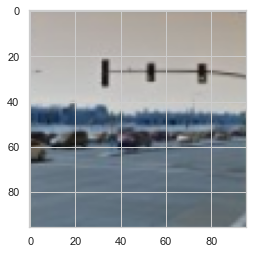

In [6]:
imglist = list()


for dr in os.listdir(data_path) :
    if dr not in ['Traffic Light','Palm','Hydrant','Crosswalk','Car','Bus','Bicycle'] :
        continue
    img_path = os.path.join(data_path,dr)
    print(dr)
    for img in tqdm(os.listdir(img_path) ):
        path = os.path.join(img_path,img)
        pic = cv2.imread(path)
        pic = cv2.resize(pic,(96,96))
        plt.imshow(pic)
        pic=sharpen(pic)
        pic = enhance_contrast(pic)
        imglist.append([pic,dr])

In [8]:
X,y_temp = map(list,zip(*imglist))

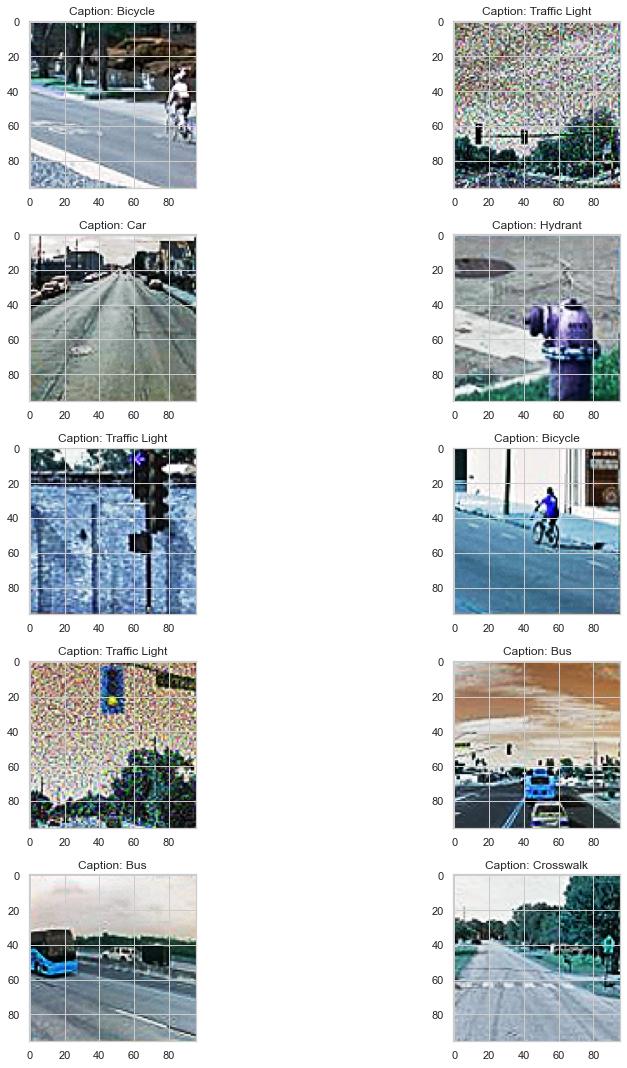

In [9]:
# just checking if x and y are mapped correctly
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(y_temp))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Caption: '+y_temp[l])
        
plt.tight_layout()

In [10]:
#le -> performing one hot encoding( # [1,0,0,0,0], [0,1,0,0,0])
le = LabelEncoder()
Y = le.fit_transform(y_temp)
Y = to_categorical(Y,7)

# normalization of the X-label between 0 and 1
X=np.array(X)
X=X/255

In [11]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state=42)

In [13]:
#making cnn model

model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),input_shape=(96,96,3),padding='Same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=96,kernel_size=(2,2),padding='Same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [14]:
# setting batch_size nd epooch for training the model
batch_size = 128
epooch = 50

In [15]:
# data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [16]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

C:\anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 96)        24672     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 96)       0

In [18]:
# training of the model
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epooch, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

C:\Users\Akhil Namboodiri\AppData\Local\Temp/ipykernel_10700/1054941436.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/50
59/59 [==============================] - 76s 1s/step - loss: 1.6823 - accuracy: 0.3829 - val_loss: 1.3813 - val_accuracy: 0.4674
Epoch 2/50
59/59 [==============================] - 64s 1s/step - loss: 1.3724 - accuracy: 0.4668 - val_loss: 1.1491 - val_accuracy: 0.5483
Epoch 3/50
59/59 [==============================] - 57s 962ms/step - loss: 1.1875 - accuracy: 0.5482 - val_loss: 0.9978 - val_accuracy: 0.6197
Epoch 4/50
59/59 [==============================] - 56s 944ms/step - loss: 1.0610 - accuracy: 0.6012 - val_loss: 1.1656 - val_accuracy: 0.5822
Epoch 5/50
59/59 [==============================] - 56s 937ms/step - loss: 0.9960 - accuracy: 0.6294 - val_loss: 1.2148 - val_accuracy: 0.5415
Epoch 6/50
59/59 [==============================] - 56s 947ms/step - loss: 0.9570 - accuracy: 0.6403 - val_loss: 0.9966 - val_accuracy: 0.6312
Epoch 7/50
59/59 [==============================] - 58s 978ms/step - loss: 0.9039 - accuracy: 0.6654 - val_loss: 0.9663 - val_accuracy: 0.6562
Epoch

In [21]:
# saving the model
model.save_weights('C:/Users/Akhil Namboodiri/Downloads/recaptcha-dataset-main/recaptcha-dataset-main/cnn_base.h5')

In [22]:
with open('C:/Users/Akhil Namboodiri/Downloads/recaptcha-dataset-main/recaptcha-dataset-main/cnn_base.json', "w") as json_file:
    json_file.write(model.to_json())

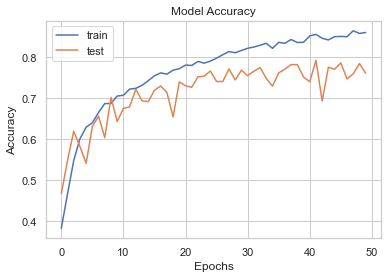

In [23]:
#accuracy graph of our model
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [24]:
#import our model from json
with open('C:/Users/Akhil Namboodiri/Downloads/recaptcha-dataset-main/recaptcha-dataset-main/cnn_base.json', 'r') as f:
    loaded_model_json = f.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('C:/Users/Akhil Namboodiri/Downloads/recaptcha-dataset-main/recaptcha-dataset-main/cnn_base.h5')

In [25]:
# some debugging
pred = loaded_model.predict(x_test)
pred_final = np.argmax(pred,axis=1)
pred_final=pred_final.reshape(1917,1)
pred_final

array([[2],
       [2],
       [4],
       ...,
       [2],
       [4],
       [3]], dtype=int64)

['Bicycle']
[array([0], dtype=int64)]
0
Bicycle


C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


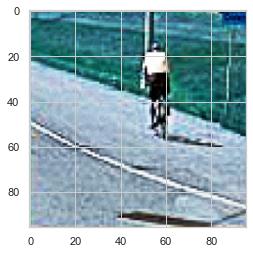

In [26]:
# print(le.inverse_transform(y_test[0]),pred_final[0])
d = {0:'Bicycle',1:'Bus',2:'Car',3:'Crosswalk',4:'Hydrant',5:'Palm',6:'Traffic Light'}
print(str(le.inverse_transform([pred_final[282]])))
print(str([pred_final[282]]))
print(np.argmax([y_test[282]]))
print(d[np.argmax([y_test[282]])])
plt.imshow(x_test[282])

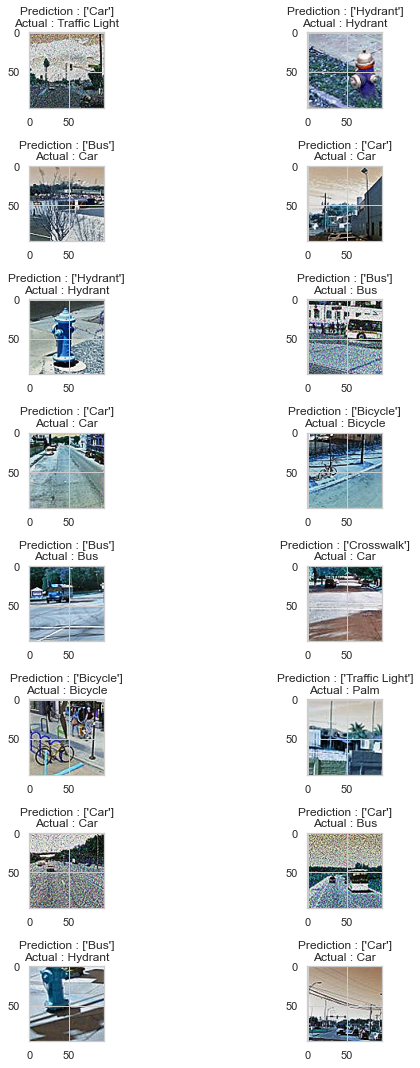

In [27]:
# checking our result. Comparing some of the predicted and test values
count=0
fig,ax=plt.subplots(8,2)
fig.set_size_inches(15,15)
for i in range (8):
    for j in range (2):
        ax[i,j].imshow(x_test[count])
        ax[i,j].set_title("Prediction : "+str(le.inverse_transform([pred_final[count]]))+"\n"+"Actual : "+d[np.argmax([y_test[count]])])
        plt.tight_layout()
        count+=2

In [28]:
x_test

array([[[[0.69411765, 0.76862745, 0.61568627],
         [0.83921569, 0.90980392, 0.67843137],
         [0.82352941, 0.89019608, 0.56078431],
         ...,
         [0.83921569, 0.88235294, 0.91764706],
         [0.65490196, 0.76470588, 0.80392157],
         [0.65490196, 0.6627451 , 0.79215686]],

        [[0.45098039, 0.42745098, 0.36862745],
         [0.38431373, 0.37647059, 0.27843137],
         [0.49803922, 0.48235294, 0.3372549 ],
         ...,
         [0.76862745, 0.74901961, 0.76078431],
         [0.82352941, 0.85882353, 0.86666667],
         [0.74509804, 0.85882353, 0.90196078]],

        [[0.72941176, 0.64705882, 0.64313725],
         [0.49803922, 0.37647059, 0.37254902],
         [0.55686275, 0.45882353, 0.43921569],
         ...,
         [0.76078431, 0.68627451, 0.68627451],
         [0.57647059, 0.60392157, 0.58823529],
         [0.7372549 , 0.9254902 , 0.87058824]],

        ...,

        [[0.30196078, 0.25490196, 0.39215686],
         [0.25882353, 0.31372549, 0.32941176]

In [29]:
pred = loaded_model.predict(x_test)
pred_final = np.argmax(pred,axis=1)
pred_final=pred_final.reshape(1917,1)
pos = 0
for i in range(1917):
    if y_test[i][pred_final[i]] == 1:
        pos += 1
accuracy = pos/len(y_test)
accuracy*100

76.10850286906626